In [1]:
import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

import pickle

from utilis import visualize, plot_data

from xmljson import badgerfish as bf
from xml.etree.ElementTree import fromstring

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/Users/haohe/Documents/HKUST/competition/data/VisDrone2021-COUNTING/DroneRGBT'
train_images = path + '/Train/RGB'
train_images_TIR = path + '/Train/TIR'
anno = path + '/Train/GT_'
dmap_folder = path + '/Train/DMAP'

In [28]:
class TrainGlobalConfig:
    num_workers = 0
    batch_size = 4
    n_epochs = 40 # n_epochs = 40
    lr = 0.0002

    folder = 'test_delete'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    scheduler_params = dict(
        max_lr=1e-3,
        total_steps = len(train_dataset) // 4 * n_epochs,
        #epochs=n_epochs,
        #steps_per_epoch=int(len(train_dataset) / batch_size),
        pct_start=0.3,
        anneal_strategy='cos', 
        final_div_factor=10**5
    )
    
#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )

In [3]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomSizedCrop(min_max_height=(409, 512), height=409, width=512, p=1.0),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=1.0),
        ],
        #additional_targets={'image': 'image','image1': 'image'}
        keypoint_params = A.KeypointParams(format='xy')
)

def get_train_image_only_transforms():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.Blur(blur_limit=3,p=0.2),
            A.Normalize(p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ],
        additional_targets={'image': 'image'}
    )

def get_valid_trainsforms():
    return A.Compose(
        [
            A.Normalize(p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ]
    )

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def denormalize(img):
    img = img * std[...,None,None] + mean[...,None,None]
    img = img.permute(1,2,0).cpu().numpy()
    return img

In [4]:
class Counting_Dataset(Dataset):
    def __init__(self,path,image_fnames,dmap_folder,gt_folder=None,transforms=None,mosaic=False,downsample=4):
        '''
            path: root path 
            image_fnames: path of images
            dmap_folder: density map folder, eg: /dmap
            gt_folder: gt folder, currently set to visdrone xml format, modify _get_gt_data() if needed
            transforms: iteratable, can be tuple / list ... etc
            mosaic: mix up image and density map to form a new image, set to false by default
            downsample: resize dmap
        '''
        super().__init__()
        self.path = path
        self.image_fnames = image_fnames
        self.dmap_folder = path + dmap_folder
        self.transforms = transforms
        self.mosaic = mosaic
        self.downsample = downsample
        self.gt_folder = gt_folder # test purpose
        
    def __len__(self):
        return len(self.image_fnames)
    
    def __getitem__(self,idx):
        image_id = self.image_fnames[idx]
        
        if self.mosaic and random.randint(0,1) < 0.5:
            image, density_map, gt_points = self._load_mosaic_image_and_density_map(idx)
        else:
            image, density_map, gt_points = self._load_image_and_density_map(idx)
        
        density_map = cv2.resize(density_map,(image.shape[1]//self.downsample, image.shape[0]//self.downsample))
        
        # Warning: doesn't work for cutout, uncommet transform and make fix code to enable cutout
        # Reason: cutout doesn't apply to mask, so mask must be image. check 01a bottom for code
        for tfms in self.transforms:
            aug = tfms(**{
                'image': image,
                'mask': density_map,
                'keypoints': gt_points
            })
            image, density_map, gt_points = aug['image'], aug['mask'], aug['keypoints']
        
        
        return image, density_map, image_id, gt_points
        
    
    def _get_dmap_name(self,fn):
        mask_name = fn.split('/')[-1].split('.')[0]
        mask_path = self.dmap_folder + '/' + mask_name + 'Dmap.pkl'
        return mask_path
    
    def _load_image_and_density_map(self,idx):
        image_fname = self.image_fnames[idx]
        dmap_fname = self._get_dmap_name(image_fname)
        image = cv2.imread(image_fname)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.
        d_map = np.load(dmap_fname,allow_pickle=True)
        
        #sanity check gt
        _, points = self._get_gt_data(idx)
        # end sanity check
        
        return image, d_map, points
    
    def _load_mosaic_image_and_density_map(self,idx):
        image_1, dmap_1, points_1 = self._load_image_and_density_map(idx)
        while True:
            idx_2 = random.randint(0,len(self.image_fnames)-1)
            if idx != idx_2:
                break
        image_2, dmap_2, points_2 = self._load_image_and_density_map(idx_2)
        
        imsize = min(*image_1.shape[:2])
        xc,yc = [int(random.uniform(imsize*0.4,imsize*0.6)) for _ in range(2)]
        h,w = image_1.shape[0], image_1.shape[1]

        pos = random.randint(0,1)
        if pos == 0: #top left
            x1a,y1a,x2a,y2a = 0,0,xc,yc # img_1
            x1b,y1b,x2b,y2b = w-xc,h-yc,w,h # img_2
        elif pos == 1: # top right
            x1a,y1a,x2a,y2a = w-xc,0,w,yc
            x1b,y1b,x2b,y2b = 0,h-yc,xc,h
        elif pos == 2: # bottom left
            x1a,y1a,x2a,y2a = 0,h-yc,xc,h
            x1b,y1b,x2b,y2b = w-xc,0,w,yc
        elif pos == 3: # bottom right
            x1a,y1a,x2a,y2a = w-xc,h-yc,w,h
            x1b,y1b,x2b,y2b = 0,0,xc,yc
        
        new_image = image_1.copy()
        new_dmap = dmap_1.copy()
        new_image[y1a:y2a,x1a:x2a] = image_2[y1b:y2b,x1b:x2b]
        new_dmap[y1a:y2a,x1a:x2a] = dmap_2[y1b:y2b,x1b:x2b]
        
        #TODO: sanity check to see generate gt
        
        new_gt_points = self._get_mixed_gt_points(points_1,points_2,(x1a,y1a,x2a,y2a),(x1b,y1b,x2b,y2b),(h,w))
        
        return new_image, new_dmap, new_gt_points
    
    '''
    The follow section blocks are for sanity check 
    to compare dmap.sum() with gt points
    remove if needed
    '''
    def _get_mixed_gt_points(self,points_1,points_2,img_1_loc, img_2_loc,img_shape):
#         fn_1, points_1 = self._get_gt_data(idx_1)
#         fn_2, points_2 = self._get_gt_data(idx_2)
        x1a,y1a,x2a,y2a = img_1_loc
        x1b,y1b,x2b,y2b = img_2_loc
        h,w = img_shape
        
        result_boxes = []
        result_boxes.append(points_2)
        result_boxes = np.concatenate(result_boxes,0)
        padw = x1a-x1b
        pady = y1a-y1b

        result_boxes[:,0] += padw
        result_boxes[:,1] += pady

        np.clip(result_boxes[:,0],0,w+1,out=result_boxes[:,0])
        np.clip(result_boxes[:,1],0,h+1,out=result_boxes[:,1])
        result_boxes = result_boxes.astype(np.int32)

        result_boxes = result_boxes[np.where(result_boxes[:,0] * result_boxes[:,1] > 0)]
        result_boxes = result_boxes[np.where(result_boxes[:,0] < w+1)]
        result_boxes = result_boxes[np.where(result_boxes[:,1] < h+1)]
        
        boxes = []
        for (x,y) in points_1:
            if x >= x1a and x <= x2a and y >= y1a and y <= y2a:
                continue
            else:
                boxes.append((x,y))
        return np.concatenate((boxes, result_boxes),axis=0)
    
    def _get_gt_data(self,idx):
        if not self.gt_folder:
            return (None,0)
        fn = self.image_fnames[idx]
        anno_path = self.path + self.gt_folder + '/' + fn.split('/')[-1].split('.')[0] + 'R.xml'
        with open(anno_path,'r') as f:
                data = f.read()
        test_data = bf.data(fromstring(data))
        points = self._get_annotation(test_data)
        return fn, points
        
    
    def _get_annotation(self,xml_datas):
        points = []
        for data in xml_datas['annotation']['object']:
            if data['name']['$'] == 'person':
                if 'point' in data:
                    x = data['point']['x']['$']
                    y = data['point']['y']['$']
                else:
                    x = data['bndbox']['xmin']['$']
                    y = data['bndbox']['ymin']['$']
                points.append((x,y))
            else: print(data['name']['$'] +' not a person...')
        return points
        

In [5]:
split = 1659

In [6]:
files = sorted(glob(train_images+'/*.jpg'),key=lambda x: int(x.split('/')[-1].split('.')[0]))

In [7]:
train_images = files[:split]
valid_images = files[split:]

In [8]:
train_dataset = Counting_Dataset(path=path,
                                 image_fnames=train_images,dmap_folder='/Train/DMAP',
                                 gt_folder='/Train/GT_',
                                 transforms=[get_train_transforms(),get_train_image_only_transforms()],
                                 mosaic=True
                                )

valid_dataset = Counting_Dataset(path=path,
                                 image_fnames=valid_images,dmap_folder='/Train/DMAP',
                                 gt_folder='/Train/GT_',
                                 transforms=[get_valid_trainsforms()]
                                )

In [74]:
def collate_fn(batch):
    imgs, dmaps, fns, gt_points = zip(*batch)
    imgs = torch.stack(imgs)
    dmaps = torch.stack(dmaps).unsqueeze(1)
    return imgs,dmaps,fns,gt_points

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TrainGlobalConfig.batch_size,
    sampler=RandomSampler(train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=TrainGlobalConfig.num_workers,
    collate_fn=collate_fn,
)

val_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=TrainGlobalConfig.batch_size,
    num_workers=TrainGlobalConfig.num_workers,
    shuffle=False,
    sampler=SequentialSampler(valid_dataset),
    pin_memory=False,
    collate_fn=collate_fn,
)

In [110]:
imgs, dmaps, fns, gt_points = next(iter(train_loader))

In [111]:
model.eval()
preds = model(imgs)

In [126]:
preds.sum(dim=[-1,-2]) * 16

tensor([[-10.7399],
        [ -0.1347],
        [ -2.4721],
        [ -8.8466]], grad_fn=<MulBackward0>)

In [127]:
dmaps.sum(dim=[-1,-2]) * 16

tensor([[ 43.4265],
        [118.4887],
        [ 81.3264],
        [ 25.9935]])

In [115]:
dmaps[0].sum() * 16

tensor(43.4265)

In [116]:
len(gt_points[0])

44

In [120]:
nn.L1Loss()(preds.sum(dim=[2,3])*16,dmaps.sum(dim=[2,3])*16)

tensor(72.8571, grad_fn=<L1LossBackward>)

In [84]:
nn.MSELoss()(preds,dmaps)

tensor(2.8111e-07, grad_fn=<MseLossBackward>)

-0.552912


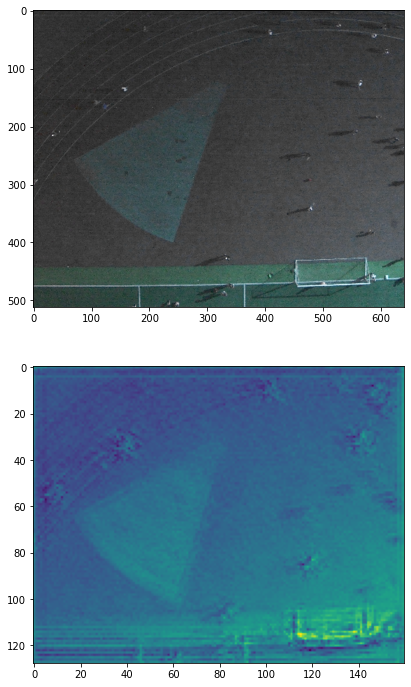

In [112]:
visualize(denormalize(imgs[3]),preds[3].detach().squeeze(0).numpy())

1.1080407


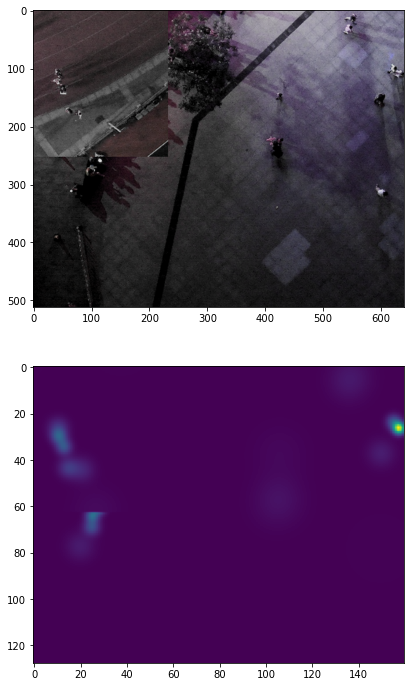

In [90]:
visualize(denormalize(imgs[0]),dmaps[0].detach().squeeze(0).numpy())

In [91]:
dmaps[0].detach().sum()

tensor(1.1080)

In [92]:
preds[0].detach().sum()

tensor(-0.7062)

In [93]:
nn.MSELoss()(dmaps[0].detach().sum(),preds[0].detach().sum())

tensor(3.2915)

In [94]:
nn.MSELoss()(dmaps[0],preds[0])

tensor(6.5820e-08, grad_fn=<MseLossBackward>)

In [79]:
'''
    credit: https://github.com/CommissarMa/MCNN-pytorch/blob/master/mcnn_model.py
'''

class MCNN(nn.Module):
    '''
    Implementation of Multi-column CNN for crowd counting
    '''
    def __init__(self,load_weights=False):
        super(MCNN,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True)
        )

        self.fuse=nn.Sequential(nn.Conv2d(30,1,1,padding=0))

        if not load_weights:
            self._initialize_weights()

    def forward(self,img_tensor):
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [133]:
def MSELoss_MCNN(preds,targs):
    return nn.MSELoss()(preds,targs)

def MAELoss_MCNN(preds,targs,upsample):
    return nn.L1Loss()(preds.sum(dim=[-1,-2])*upsample*upsample, targs.sum(dim=[-1,-2])*upsample*upsample)

In [80]:
model = MCNN()

In [132]:
MSELoss_MCNN(preds.detach(),dmaps.detach())

tensor(3.8114e-07)

In [134]:
MAELoss_MCNN(preds.detach(),dmaps.detach(),4)

tensor(72.8571)